In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43075,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:44691,Total threads: 8
Dashboard: http://127.0.0.1:46257/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:44143,


In [2]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import xarray as xr
from xmitgcm import open_mdsdataset
import numpy as np
import warnings
# warnings.filterwarnings("ignore")

data_dir = '/data/SO3/edavenport/tpose6/sep2012/sens_surf/sens_surface_0to75m/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(0,itPerFile*num_diags,itPerFile) # adjoint sensitivity will start at 0 and go to 1 lag (1 interval less than total number of timesteps)

# when prefix is not set, this will read all available files 
# have to ignore unkown vars until we have an available_diagnostics.log that includes ADJrhoinsitu
tpose_ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,ref_date='2012-09-01',delta_t=1200,ignore_unknown_vars=True)
tpose_ds['XC'] = tpose_ds.XC.astype(float)
tpose_ds['YC'] = tpose_ds.YC.astype(float)
tpose_ds['Z'] = tpose_ds.Z.astype(float)
tpose_ds['XG'] = tpose_ds.XG.astype(float)
tpose_ds['YG'] = tpose_ds.YG.astype(float)


In [6]:
print(tpose_ds.ADJetan)

<xarray.DataArray 'ADJetan' (time: 122, YC: 336, XC: 1128)> Size: 185MB
dask.array<concatenate, shape=(122, 336, 1128), dtype=float32, chunksize=(1, 336, 1128), chunktype=numpy.ndarray>
Coordinates:
    iter     (time) int64 976B dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 976B 2012-09-01 2012-09-02 ... 2012-12-31
  * XC       (XC) float64 9kB 104.1 104.2 104.4 104.6 ... 291.6 291.8 291.9
  * YC       (YC) float64 3kB -25.92 -25.75 -25.58 -25.42 ... 29.58 29.75 29.92
    rA       (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    Depth    (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    dxF      (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
    dyF      (YC, XC) >f4 2MB dask.array<chunksize=(336, 1128), meta=np.ndarray>
Attributes:
    standard_name:  ADJetan
    long_name:      dJ/dEtaN: Sensitivity to sea surface height anomaly
    units:          dJ/m


In [ ]:
spectrum = np.abs(np.fft.fft2(tpose_ds.ADJetan, axes=(0, 2)))**2  # power spectrum over (t, x)

In [102]:
spectrum_etan = tpose_ds.ADJetan.copy(deep=True)
spectrum_etan.values = spectrum
spectrum_avg = spectrum_etan.mean(dim='YC')

nt = tpose_ds.sizes['time']
nx = tpose_ds.sizes['XC']

dt = 1  # time step
dx = float(tpose_ds['XC'].diff('XC').mean()) * 111.3       # spatial step

freqs = np.fft.fftfreq(nt, dt)  # cycles per unit time
wavenums = np.fft.fftfreq(nx, dx)  # cycles per unit distance

In [103]:
print(dx)

18.54999874423009


In [104]:
freqs = 1/(np.fft.fftshift(freqs))
wavenums = 1/(np.fft.fftshift(wavenums))
freqs[len(freqs)//2] = 0
wavenums[len(wavenums)//2] = 0
spectrum_avg = np.fft.fftshift(spectrum_avg, axes=(0, 1))  # shift freq and wavenumber dims


/tmp/ipykernel_3686609/3758697296.py:1: RuntimeWarning: divide by zero encountered in divide
  freqs = 1/(np.fft.fftshift(freqs))
/tmp/ipykernel_3686609/3758697296.py:2: RuntimeWarning: divide by zero encountered in divide
  wavenums = 1/(np.fft.fftshift(wavenums))


In [105]:
print(freqs)

[  -2.           -2.03333333   -2.06779661   -2.10344828   -2.14035088
   -2.17857143   -2.21818182   -2.25925926   -2.30188679   -2.34615385
   -2.39215686   -2.44         -2.48979592   -2.54166667   -2.59574468
   -2.65217391   -2.71111111   -2.77272727   -2.8372093    -2.9047619
   -2.97560976   -3.05         -3.12820513   -3.21052632   -3.2972973
   -3.38888889   -3.48571429   -3.58823529   -3.6969697    -3.8125
   -3.93548387   -4.06666667   -4.20689655   -4.35714286   -4.51851852
   -4.69230769   -4.88         -5.08333333   -5.30434783   -5.54545455
   -5.80952381   -6.1          -6.42105263   -6.77777778   -7.17647059
   -7.625        -8.13333333   -8.71428571   -9.38461538  -10.16666667
  -11.09090909  -12.2         -13.55555556  -15.25        -17.42857143
  -20.33333333  -24.4         -30.5         -40.66666667  -61.
 -122.            0.          122.           61.           40.66666667
   30.5          24.4          20.33333333   17.42857143   15.25
   13.55555556   12.2     

In [106]:
W, F = np.meshgrid(wavenums, freqs)  # W = wavenumber grid, F = frequency grids

In [ ]:
pos_freq_idx = freqs > 0
pos_wavenum_idx = wavenums > 0

W_pos, F_pos = np.meshgrid(wavenums[pos_wavenum_idx], freqs[pos_freq_idx])
spec_pos = spectrum_avg[pos_freq_idx, :][:, pos_wavenum_idx]

In [111]:
# Constants
c = 2.8  # m/s, Kelvin wave speed
beta = 2.28e-11  # 1/m/s, equatorial beta
Lr = np.sqrt(c / beta)  # Rossby radius (m)

# Define wavelength in km
lambda_km = np.logspace(1, 4, 500)  # 10 km to 10,000 km
lambda_m = lambda_km * 1000  # convert to meters

# --- Kelvin wave ---
T_kelvin_days = (2 * np.pi * lambda_m) / (c * 86400)

# --- Rossby wave ---
k_m = 2 * np.pi / lambda_m  # zonal wavenumber in rad/m
omega_rossby = - (beta * k_m) / (k_m**2 + (1 / Lr)**2)  # rad/s
T_rossby_days = (2 * np.pi) / np.abs(omega_rossby) / 86400  # rad/seconds -> days/cycle

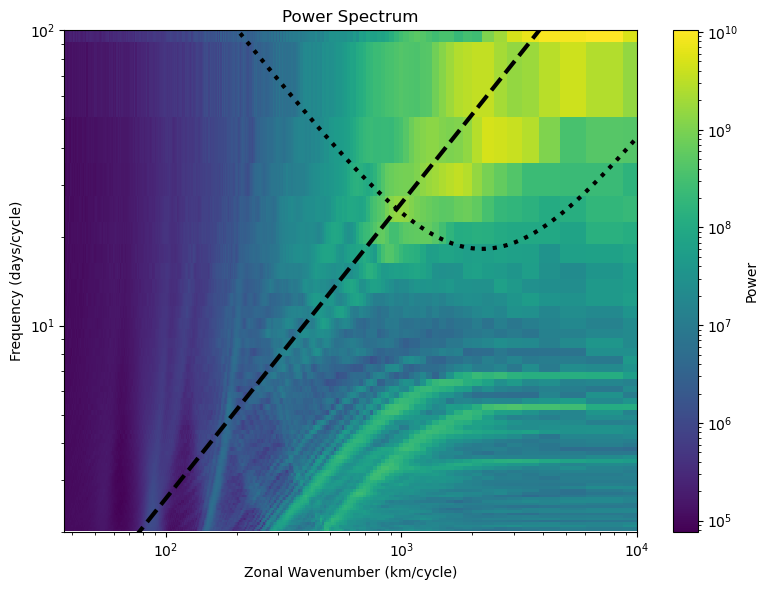

In [112]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(W_pos, F_pos, spec_pos, shading='auto', cmap='viridis', norm=LogNorm())
plt.plot(lambda_km, T_kelvin_days, label='Kelvin wave (c = 2.8 m/s)', color='black', linestyle='--',linewidth=3)
plt.plot(lambda_km, T_rossby_days, label='Rossby wave (baroclinic, β-plane)', color='black', linestyle=':',linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(dx*2, 10000)  # Wavenumber in km/cycle
plt.ylim(2, 100)  # Frequency in days/cycle
plt.xlabel('Zonal Wavenumber (km/cycle)')
plt.ylabel('Frequency (days/cycle)')
plt.title('Power Spectrum')
plt.colorbar(pcm, label='Power')
plt.tight_layout()
plt.show()

In [113]:
client.shutdown()